# Evidential Deep Regression on sparse dataset

In [2]:
import joblib
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


# import evidential library
import evidential_deep_learning as edl

from matplotlib import pyplot as plt  
import uncertainty_toolbox as uct

# goat3 import methods 
from goat3.pipeline import PandasPipeline, ColumnsSelector
from goat3.validation import plot_adequation, plot_residuals, plot_confidence, plot_confidence_v2, plot_cumulative
from goat3 import create_fully_connected
from goat3.validation._validation import table_results

#imported to hide tensorflow & plot warnings
import warnings
warnings.filterwarnings('ignore')

2022-08-22 15:54:36.315750: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-22 15:54:36.321052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 15:54:36.321063: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load & Preprocess data

In [4]:
#load data
data = pd.read_pickle('../../../Data/Sparse_data.pkl')

# Split data traning and target.
y = data['y']
X = data.drop(["y"], axis=1)

#Split data into training and testing sets
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)

# data shapes summary
print(f"\nTraining Data : {X_train.shape}")
print(f"Testing Data  : {X_test.shape}\n")


Training Data : (8817, 753)
Testing Data  : (980, 753)



## Model 

In [69]:
BS = 32 # Batch Size
EPOCHS = 50 # Number of Epochs

# Define the model with an evidential output 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(10, activation="relu"),
    edl.layers.DenseNormalGamma(1),
])

# define the evidential loss function 
def EvidentialRegressionLoss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)

# compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss=EvidentialRegressionLoss,
    metrics=['mae'])

# Train model
print("[INFO] training ...")
history = model.fit(X_train, y_train,batch_size = BS, epochs=EPOCHS, validation_split=0.1,verbose = 0)
print("[INFO] done!")

[INFO] training ...
[INFO] done!


In [70]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

31/31 [==============================] - 0s 1ms/step


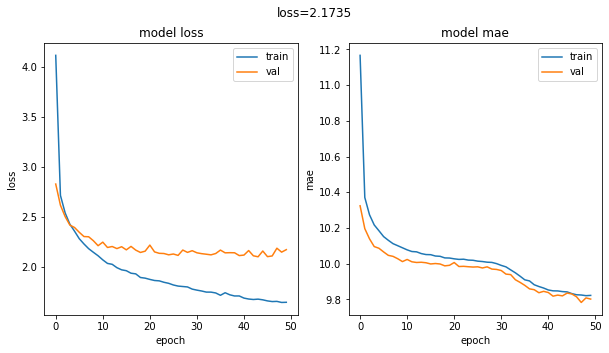

In [71]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.suptitle("loss={:5.4f}".format(history.history["val_loss"][-1]))

plt.show()

Text(0.5, 1.0, 'comparing the two types of uncertainties')

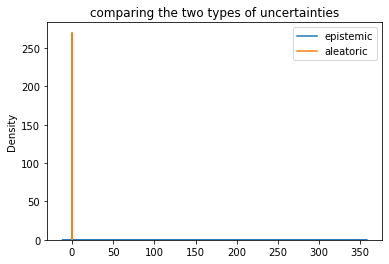

In [72]:

# Split the output to get the 4 parameters mu, alpha, v, beta for the TEST SET
mu, v, alpha, beta = tf.split(y_test_pred, 4, axis=-1)
mu = mu[:, 0]
var = np.sqrt(beta / (v * (alpha - 1)))
var = np.minimum(var, 1e3)[:, 0]

# Split the output to get the 4 parameters mu, alpha, v, beta for the TRAIN SET
mu_tr, v_tr, alpha_tr, beta_tr = tf.split(y_train_pred, 4, axis=-1)
mu_tr = mu_tr[:, 0]
var_tr = np.sqrt(beta_tr / (v_tr * (alpha_tr - 1)))
var_tr = np.minimum(var_tr, 1e3)[:, 0]



# Compute the two uncertainties 
alea = beta / (alpha - 1) # aleatoric uncertainty  
epist = beta / (v*(alpha - 1)) # epistemic uncertainty

# Plot the two types of uncertainties
#sns.set_theme(style="whitegrid")
sns.distplot(epist, hist = False, label = 'epistemic')
sns.distplot(alea, hist = False)
plt.legend(['epistemic','aleatoric'])
plt.title("comparing the two types of uncertainties")

# Compute the evaluation metrics
#metrics = uct.metrics.get_all_metrics(np.array(mu), np.array(var), np.array(y_test))
#uct.viz.plot_calibration(np.array(mu),  np.array(var) , np.array(y_test))
#plot_confidence_v2(y_test,np.array(mu) , np.array(mu)-3*var, np.array(mu)+3*var, label='source test')

In [73]:
mu = np.array(mu)
mu.shape

(980,)

In [74]:
var.shape

(980,)

In [75]:
y_test = np.reshape(y_test, newshape=var.shape)

## Calibration

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

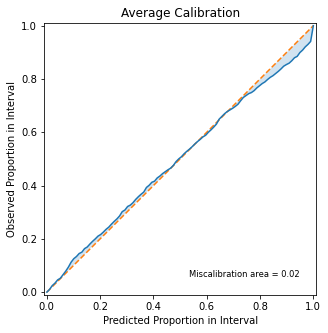

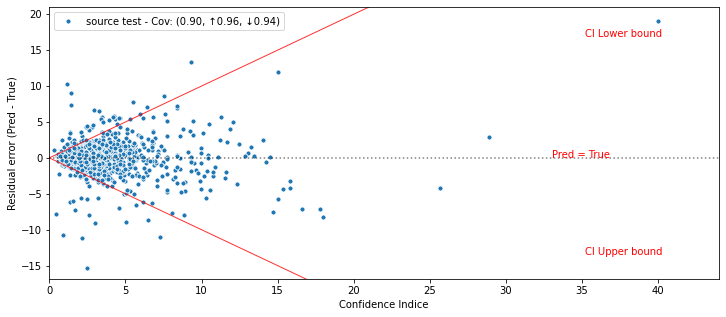

In [76]:
# Get the calibration function (fitted calibrator)
recalibrator = uct.recalibration.get_std_recalibrator(np.array(mu),  np.array(var), np.array(y_test), criterion='ma_cal')


# Get the new standard deviations 
new_stds = recalibrator(var)

# Plot the calibration curve
uct.viz.plot_calibration(np.array(mu),  np.array(new_stds) , np.array(y_test))

# Plot the Coverage curve
plot_confidence_v2(y_test,np.array(mu) , np.array(mu)-2*new_stds, np.array(mu)+2*new_stds, label='source test')



In [77]:
# Compute the metrics
metrics = uct.metrics.get_all_metrics(np.array(mu), np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.572
  RMSE          2.469
  MDAE          0.968
  MARPD         12.192
  R2            0.692
  Correlation   0.836
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.022
  Mean-absolute Calibration Error       0.017
  Miscalibration Area                   0.017
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.059
     Group Size: 0.56 -- Calibration Error: 0.028
     Group Size: 1.00 -- Calibration Error: 0.017
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.059
     Group Size: 0.56 -- Calibration Error: 0.033
     Group Size: 1.00 -- Calibration Error: 0.022
===============

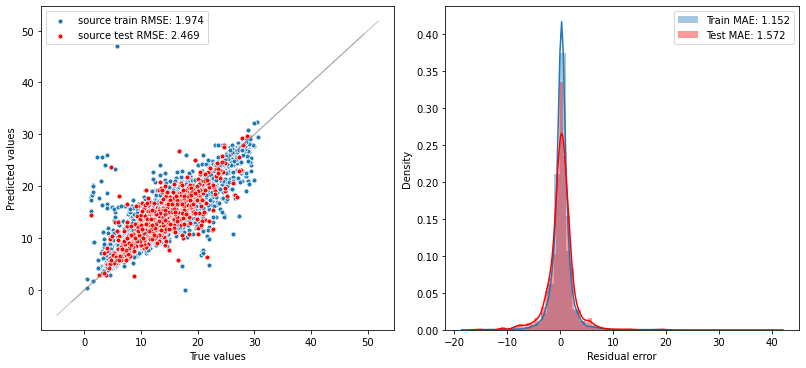

In [78]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0]);ax2 = fig.add_subplot(gs[0, 1]);

plot_adequation(y_train, np.array(mu_tr), label='source train',  ax=ax1, score='RMSE')
plot_adequation(y_test,np.array(mu), label='source test', ax=ax1,score='RMSE', color='red')
ax1.grid(False)
plot_residuals(y_train, np.array(mu_tr), kind='hist', label='Train', ax=ax2, score='MAE')
plot_residuals(y_test, np.array(mu), kind='hist', label='Test', ax=ax2, score='MAE', color ='red')
ax2.grid(False)

In [79]:
import pickle

In [81]:
with open('DER_metrics_sparse.pkl', 'wb') as f:
    pickle.dump(metrics, f)